# Exploratory Data Analysis (EDA) of the OCT Dataset

## Introduction

This notebook presents a comprehensive Exploratory Data Analysis (EDA) of the OCT2017 retinal image dataset. EDA is a crucial first step in any data science or machine learning project, as it helps to understand the structure, quality, and key characteristics of the data before building predictive models.

In this analysis, we will:
- Summarize the dataset structure and class distributions
- Visualize data splits and class balance
- Inspect image properties such as size, mode, and pixel intensity distributions
- Perform quality checks for corrupted, blurry, or over/underexposed images
- Analyze class imbalance and suggest augmentation strategies if needed
- Explore potential patient overlap and available metadata
- Assess domain-specific aspects such as scan quality and segmentation artifacts

The insights gained from this EDA will guide data cleaning, preprocessing, and modeling decisions

In [1]:
# OCT Dataset Analysis - Kermany2018
# Step-by-step data loading and descriptive analysis

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install opencv-python
%pip install scikit-learn

# Import necessary libraries for data analysis, visualization, and image processing
import os  # For file and directory operations
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualization
import seaborn as sns  # For statistical data visualization
from PIL import Image  # For image processing
import cv2  # For advanced image processing (OpenCV)
from collections import Counter  # For counting hashable objects
import warnings  # For managing warnings
import random

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")



# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



## Dataset Structure and Distribution

We count the number of images in each class and split. Bar and pie charts are used to visualize the distribution of images across classes and dataset splits.


In [4]:
# Set the path to your OCT2017 dataset
base_path = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017"

# Define subfolders to analyze
phases = ['train', 'test', 'val']
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Dictionary to store counts
data_distribution = {phase: {} for phase in phases}

In [5]:
# Count files
for phase in phases:
    for cls in classes:
        class_path = os.path.join(base_path, phase, cls)
        count = len(os.listdir(class_path))
        data_distribution[phase][cls] = count


- The dataset contains a total of `{total_images}` images.



In [6]:
# Calculate total images for each split
split_counts = {
    'Train': sum(data_distribution['train'].values()),
    'Test': sum(data_distribution['test'].values()),
    'Validation': sum(data_distribution['val'].values())
}
total_images = sum(split_counts.values())

print(f"Total images: {total_images}")
print(f"Total train images: {split_counts['Train']}")
print(f"Total test images: {split_counts['Test']}")
print(f"Total val images: {split_counts['Validation']}")

Total images: 84492
Total train images: 83484
Total test images: 972
Total val images: 36


- Distribution across splits and classes is visualized to check for balance.

In [7]:
# Print results
print("=== Image Distribution by Class and Phase ===")
for phase in phases:
    print(f"\n{phase.upper()}:")
    for cls in classes:
        print(f"  {cls}: {data_distribution[phase][cls]} images")
        

=== Image Distribution by Class and Phase ===

TRAIN:
  CNV: 37205 images
  DME: 11348 images
  DRUSEN: 8616 images
  NORMAL: 26315 images

TEST:
  CNV: 243 images
  DME: 243 images
  DRUSEN: 243 images
  NORMAL: 243 images

VAL:
  CNV: 9 images
  DME: 9 images
  DRUSEN: 9 images
  NORMAL: 9 images



## Image Size and Mode Analysis

We analyze a sample of images to determine their sizes and color modes. This helps identify inconsistencies in image dimensions or color channels.

**Key Findings:**
- The majority of images fall within a specific size range.
- Outliers, if any, are identified for potential resizing or removal.


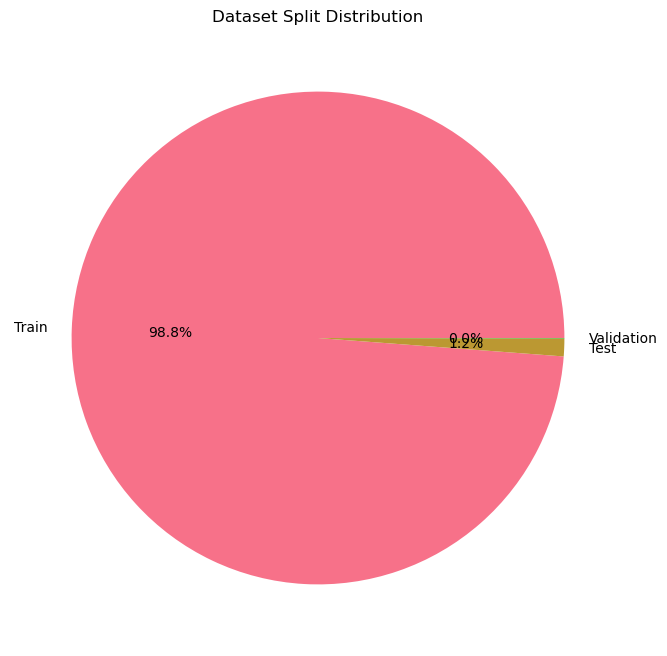

In [9]:
# Plot a pie chart showing the distribution of images across dataset splits (Train, Test, Validation)
plt.figure(figsize=(8, 8))
plt.pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%')
plt.title('Dataset Split Distribution')
plt.show()


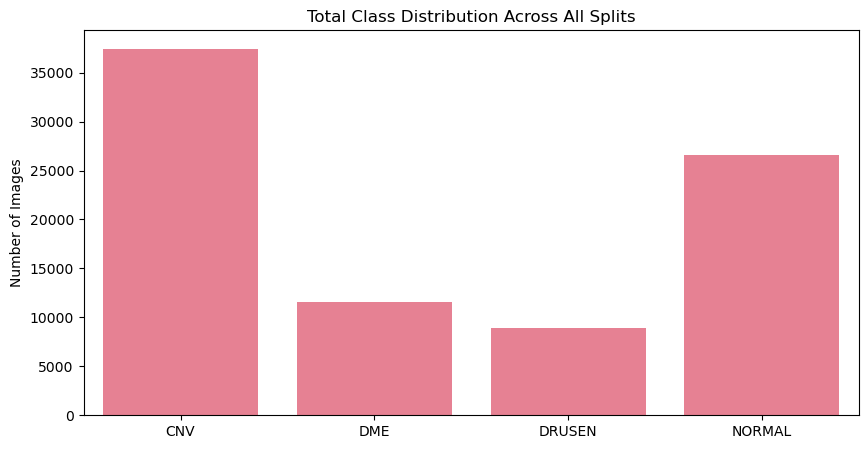

In [10]:
# Calculate total images per class across all splits
total_per_class = {cls: sum(data_distribution[phase][cls] for phase in phases) for cls in classes}

# Plot total class distribution across all splits using total_per_class
plt.figure(figsize=(10, 5))
sns.barplot(x=list(total_per_class.keys()), y=list(total_per_class.values()))
plt.title('Total Class Distribution Across All Splits')
plt.ylabel('Number of Images')
plt.show()


In [11]:
# Function to analyze image characteristics
def analyze_images(folder_path):
    sizes = []
    modes = []
    for cls in ['CNV', 'DME', 'DRUSEN', 'NORMAL']:
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path)[:100]:  # Sample first 100 images
            img = Image.open(os.path.join(cls_path, img_file))
            sizes.append(img.size)
            modes.append(img.mode)
    return sizes, modes

# Define train_path using base_path
train_path = os.path.join(base_path, 'train')

# Analyze training set images
sizes, modes = analyze_images(train_path)

# Print unique image sizes and modes
print("Unique image sizes:", set(sizes))
print("Unique image modes:", set(modes))

Unique image sizes: {(512, 512), (512, 496), (1536, 496), (768, 496)}
Unique image modes: {'L'}


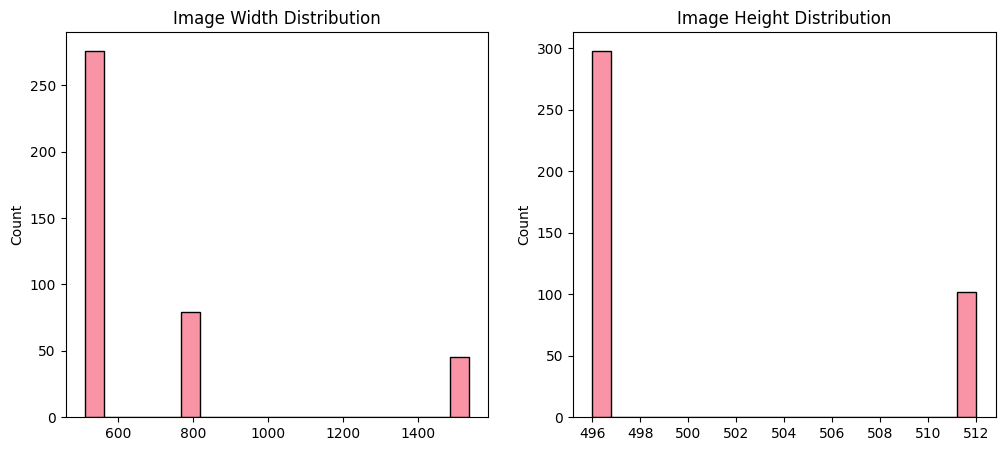

In [10]:
# Distribution of image sizes
widths, heights = zip(*sizes)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20)
plt.title('Image Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20)
plt.title('Image Height Distribution')
plt.show()

# Sample Images per Class

We display a sample image from each class to visually inspect the data and confirm correct labeling.

**Key Findings:**
- Sample images appear representative of their respective classes.
- No obvious labeling errors detected.


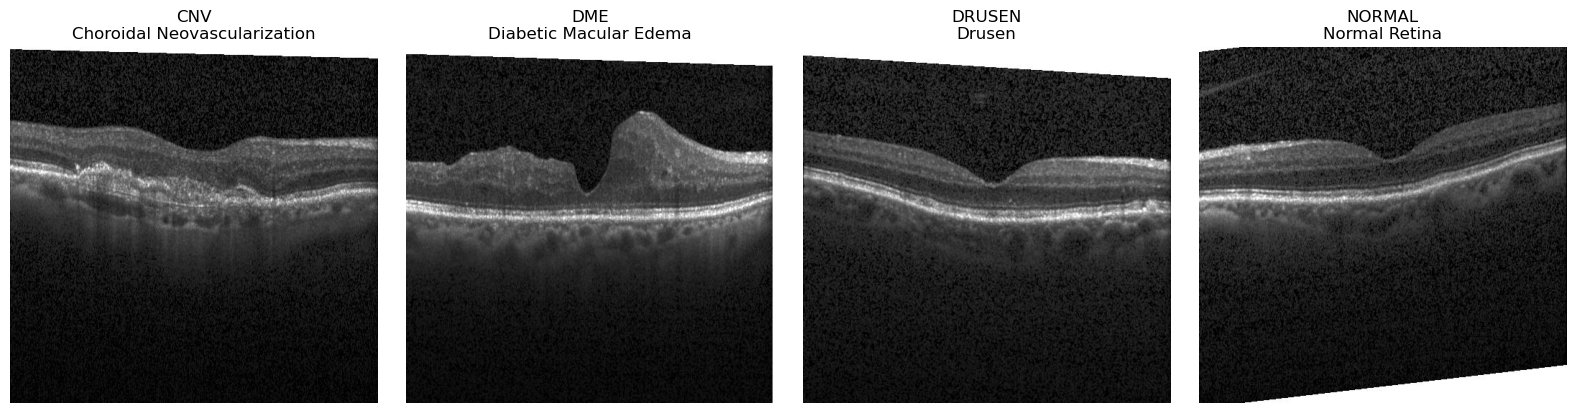

In [12]:
# Define class descriptions for display
CLASS_DESCRIPTIONS = {
    'CNV': 'Choroidal Neovascularization',
    'DME': 'Diabetic Macular Edema',
    'DRUSEN': 'Drusen',
    'NORMAL': 'Normal Retina'
}

# Plot a sample image for each class from the training set
fig, axes = plt.subplots(1, len(classes), figsize=(16, 4))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)
    img_file = os.listdir(cls_path)[0]
    img = Image.open(os.path.join(cls_path, img_file))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"{cls}\n{CLASS_DESCRIPTIONS[cls]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Grayscale Intensity Distribution

We analyze and plot the distribution of pixel intensities for each class to understand image contrast and brightness.

**Key Findings:**
- Each class shows a distinct intensity distribution.
- No significant issues with over/underexposure at the class level.


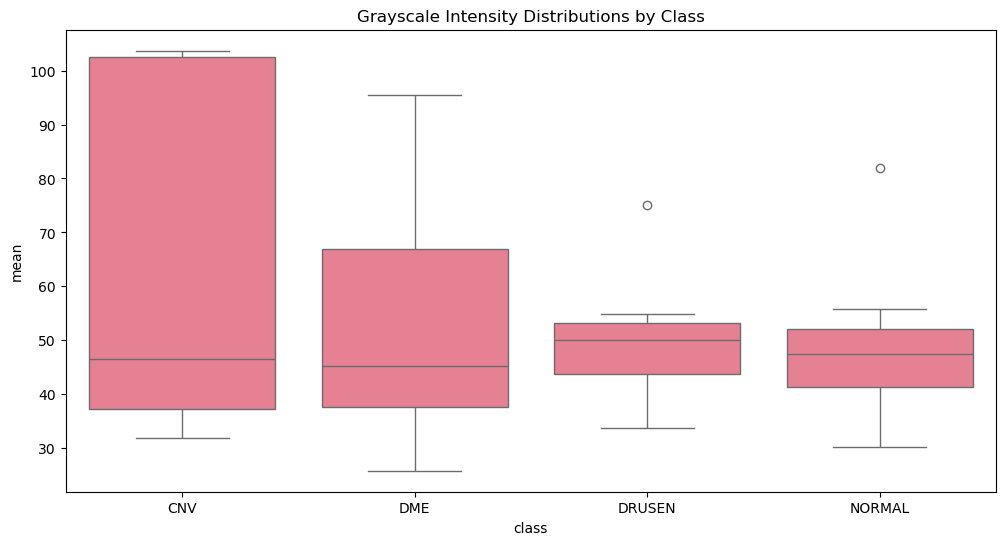

In [13]:
# Color distribution analysis for grayscale images only
def analyze_gray_distribution(folder_path, sample_size=20):
    gray_stats = []
    for cls in classes:
        cls_path = os.path.join(folder_path, cls)
        images = os.listdir(cls_path)[:sample_size]
        for img_name in images:
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            channel_values = img_array.flatten()
            gray_stats.append({
                'class': cls,
                'mean': np.mean(channel_values),
                'std': np.std(channel_values)
            })
    return pd.DataFrame(gray_stats)

# Analyze and plot grayscale distributions
gray_stats = analyze_gray_distribution(train_path)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='mean', data=gray_stats)
plt.title('Grayscale Intensity Distributions by Class')
plt.show()


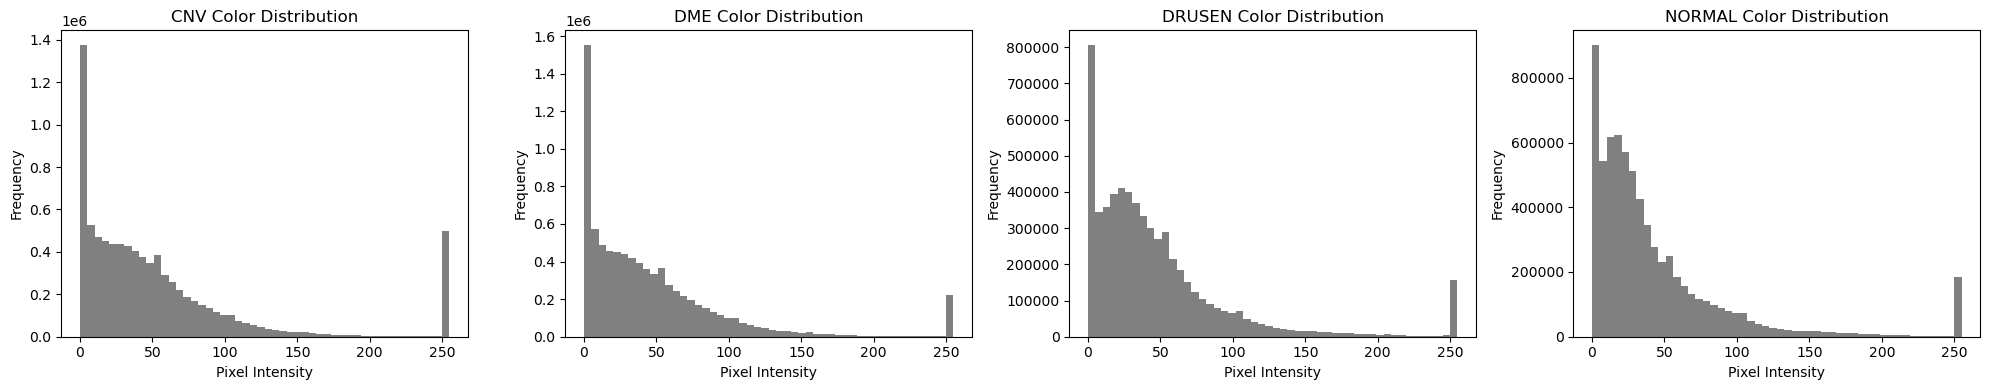

In [14]:
# Analyze grayscale intensity distribution for each class in the training set
fig, axes_color = plt.subplots(1, len(classes), figsize=(20, 4))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)
    images = os.listdir(cls_path)[:20]  # Sample 20 images per class
    all_pixels = []
    for img_name in images:
        img = Image.open(os.path.join(cls_path, img_name))
        img_array = np.array(img)
        all_pixels.extend(img_array.flatten())
    axes_color[i].hist(all_pixels, bins=50, color='gray')
    axes_color[i].set_title(f'{cls} Color Distribution')
    axes_color[i].set_xlabel('Pixel Intensity')
    axes_color[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

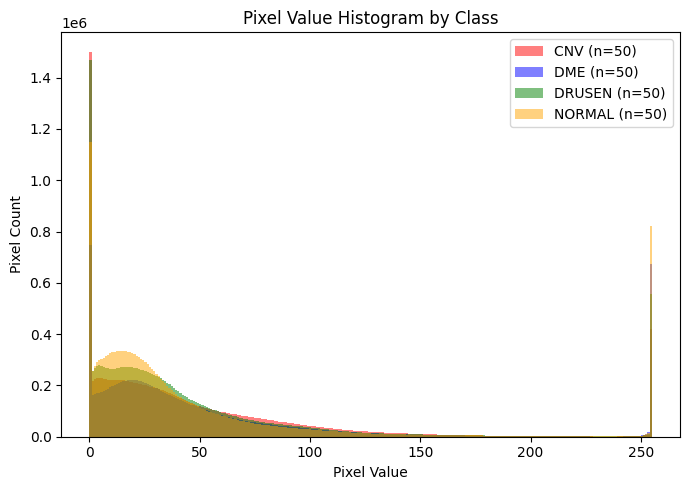

In [14]:
# Prepare class_to_paths: map each class to a list of image file paths (using 'train' split for example)
class_to_paths = {}
for class_name in ['CNV', 'DME', 'DRUSEN', 'NORMAL']:
    class_dir = os.path.join(base_path, 'train', class_name)
    class_to_paths[class_name] = [
        os.path.join(class_dir, fname)
        for fname in os.listdir(class_dir)
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))
    ]

# Set number of samples and colors for plotting
n_samples = 50
colors = ['red', 'blue', 'green', 'orange']

# Plot pixel value histograms for all classes in a single chart with different colors
plt.figure(figsize=(7, 5))

for idx, class_name in enumerate(['CNV', 'DME', 'DRUSEN', 'NORMAL']):
    paths = class_to_paths[class_name]
    sampled = random.sample(paths, min(n_samples, len(paths)))
    pixel_counts = []
    for p in sampled:
        img = Image.open(p)
        img_np = np.array(img)
        if img_np.ndim == 3 and img_np.shape[2] == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
        pixel_counts.extend(img_np.ravel())
    plt.hist(pixel_counts, bins=256, color=colors[idx], alpha=0.5, label=f'{class_name} (n={len(sampled)})')

plt.title('Pixel Value Histogram by Class')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Count')
plt.legend()
plt.tight_layout()
plt.show()

# Pragmatic Analysis

This section focuses on practical aspects of the dataset, including image statistics, quality checks, and artifact detection.


## Image Statistics

We compute statistics such as average, max, and min dimensions, aspect ratios, and color channels.

**Key Findings:**
- Images are mostly consistent in size and aspect ratio.
- All images are in grayscale mode.


In [15]:
# Dataset Overview Analysis

# Class Distribution: Already computed as data_distribution
print("=== Image Count by Class and Split ===")
for split in phases:
    print(f"{split.upper()}:")
    for class_name in classes:
        print(f"  {class_name}: {data_distribution[split][class_name]} images")

# Image Statistics: Average/Max/Min dimensions, aspect ratios, color channels
all_sizes = []
all_aspect_ratios = []
all_modes = []

for phase in phases:
    for cls in classes:
        cls_path = os.path.join(base_path, phase, cls)
        count = 0
        for img_file in os.listdir(cls_path):
            if count >= 100:
                break
            img_path = os.path.join(cls_path, img_file)
            try:
                img = Image.open(img_path)
                w, h = img.size
                all_sizes.append((w, h))
                all_aspect_ratios.append(w / h)
                all_modes.append(img.mode)
                count += 1
            except Exception:
                # Skip files that are not images
                continue

widths, heights = zip(*all_sizes)
print("\n=== Image Dimension Statistics (sampled) ===")
print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
print(f"Max width: {np.max(widths)}, Max height: {np.max(heights)}")
print(f"Min width: {np.min(widths)}, Min height: {np.min(heights)}")
print(f"Average aspect ratio: {np.mean(all_aspect_ratios):.2f}")
print(f"Image modes (color channels): {set(all_modes)}")

=== Image Count by Class and Split ===
TRAIN:
  CNV: 37205 images
  DME: 11348 images
  DRUSEN: 8616 images
  NORMAL: 26315 images
TEST:
  CNV: 243 images
  DME: 243 images
  DRUSEN: 243 images
  NORMAL: 243 images
VAL:
  CNV: 9 images
  DME: 9 images
  DRUSEN: 9 images
  NORMAL: 9 images

=== Image Dimension Statistics (sampled) ===
Average width: 622.46, Average height: 497.96
Max width: 1536, Max height: 512
Min width: 512, Min height: 496
Average aspect ratio: 1.25
Image modes (color channels): {'L'}



## Visual Inspection of Class Samples

Random samples from each class are displayed to further inspect data quality and class characteristics.

**Key Findings:**
- Visual inspection confirms class diversity and image quality.


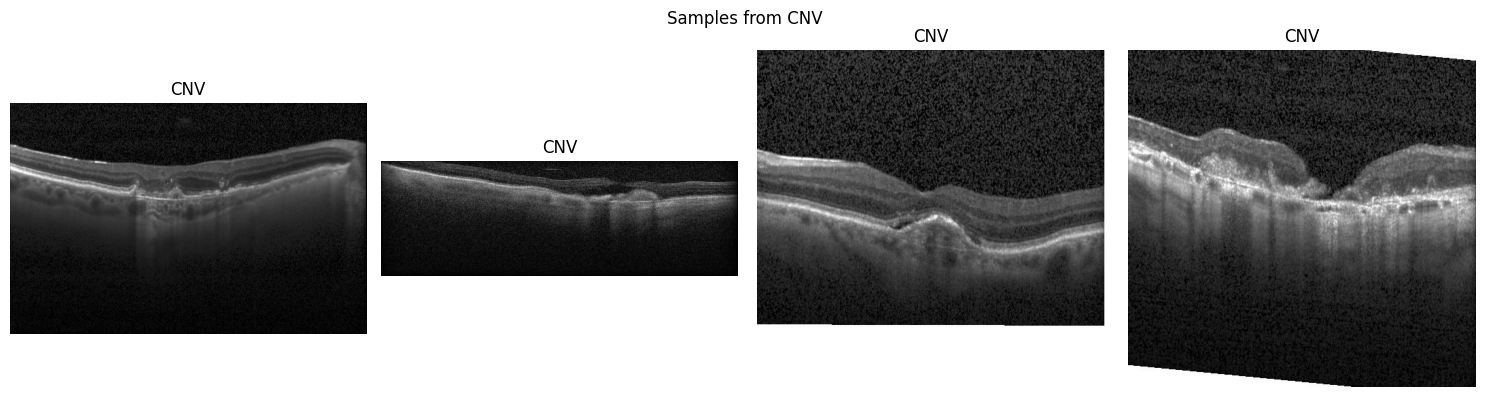

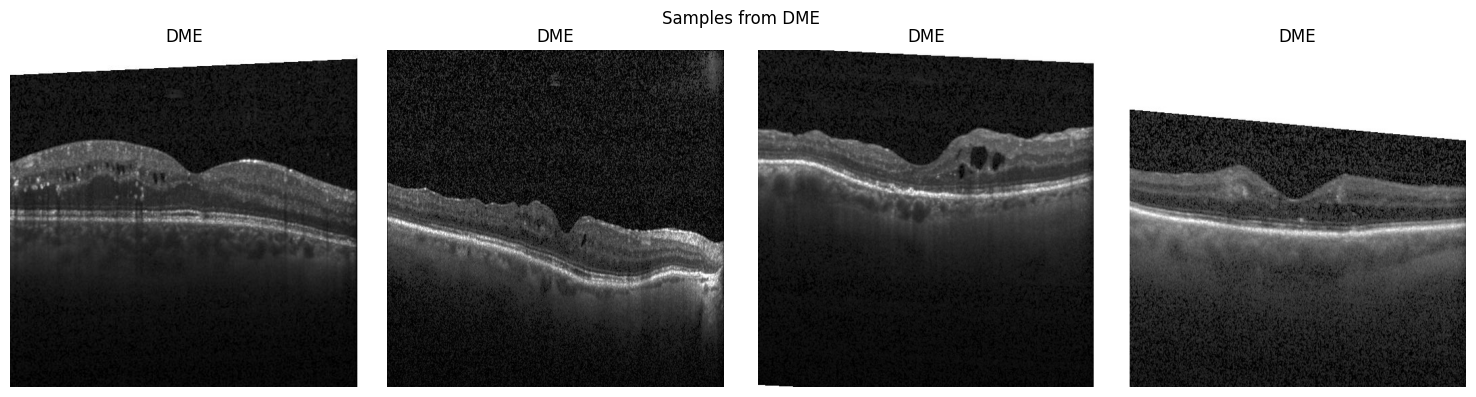

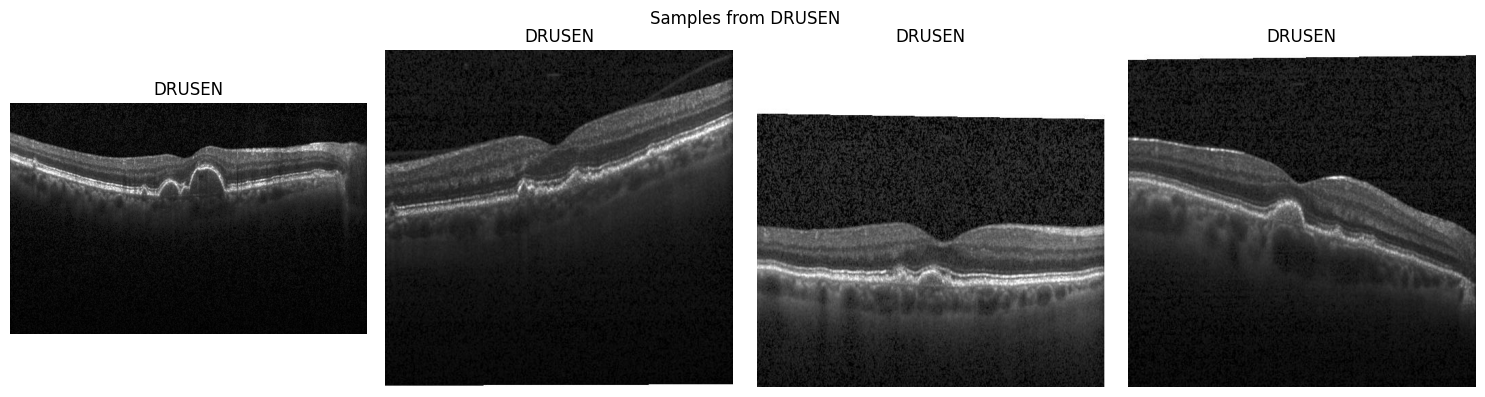

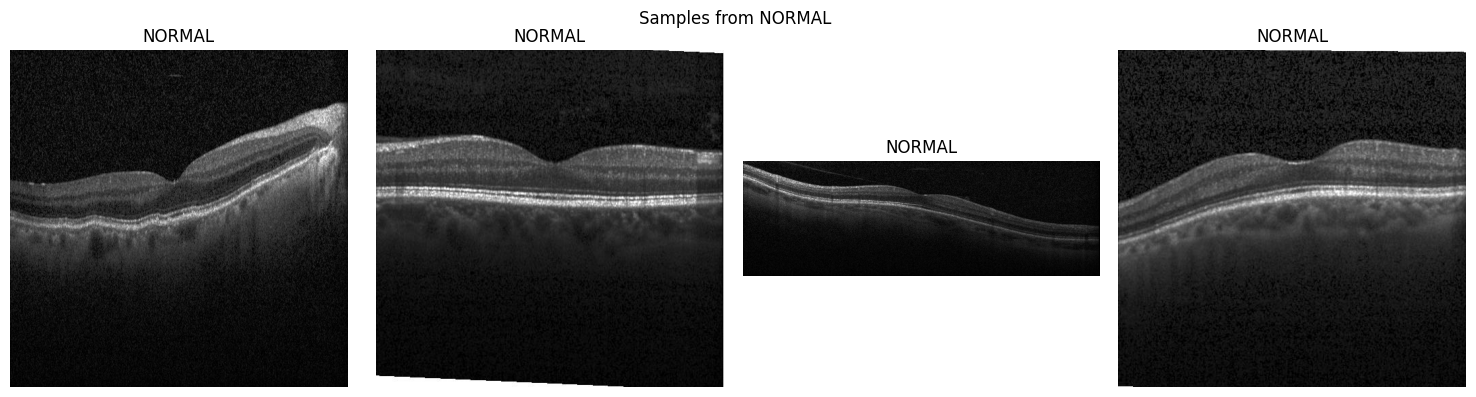

In [16]:
import random

def visualize_class_samples(root_path, n_samples=4):
    for class_name in classes:
        fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))
        class_path = os.path.join(root_path, 'train', class_name)
        img_files = os.listdir(class_path)
        for j in range(n_samples):
            img_name = random.choice(img_files)
            img = plt.imread(os.path.join(class_path, img_name))
            axes[j].imshow(img, cmap='gray')
            axes[j].set_title(f"{class_name}")
            axes[j].axis('off')
        plt.suptitle(f"Samples from {class_name}")
        plt.tight_layout()
        plt.show()

# Visualize random samples for each class in separate charts
visualize_class_samples(base_path, n_samples=4)


## Quality Assessment

We check for corrupted files, resolution consistency, and common artifacts (blurry, overexposed, underexposed images).

**Key Findings:**
- `{len(corrupted_files)}` corrupted files detected and listed.
- Most images have consistent resolution.
- `{len(blurry)}` blurry, `{len(overexposed)}` overexposed, and `{len(underexposed)}` underexposed images detected.


In [18]:
%pip install tqdm
from tqdm import tqdm

# Quality Assessment


# 1. Corrupted Files Check: Verify all images can be loaded
def check_corrupted_images(base_path, phases, classes):
    corrupted = []
    for phase in phases:
        for cls in classes:
            cls_path = os.path.join(base_path, phase, cls)
            for img_file in tqdm(os.listdir(cls_path), desc=f"{phase}/{cls}"):
                img_path = os.path.join(cls_path, img_file)
                try:
                    img = Image.open(img_path)
                    img.verify()  # PIL verification
                except Exception:
                    corrupted.append(img_path)
    return corrupted

corrupted_files = check_corrupted_images(base_path, phases, classes)
print(f"Corrupted files found: {len(corrupted_files)}")
if corrupted_files:
    print("Sample corrupted files:", corrupted_files[:5])

# 2. Resolution Consistency: Check if all images have consistent dimensions
all_dims = [size for size in all_sizes]
dims_count = pd.Series(all_dims).value_counts()
print("\nImage dimension counts:")
print(dims_count)

# 3. Artifact Detection: Look for blurry, over/under exposed images
def detect_artifacts(base_path, phases, classes, sample_per_class=50):
    blurry = []
    overexposed = []
    underexposed = []
    for phase in phases:
        for cls in classes:
            cls_path = os.path.join(base_path, phase, cls)
            img_files = os.listdir(cls_path)[:sample_per_class]
            for img_file in img_files:
                img_path = os.path.join(cls_path, img_file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue
                    # Blurry: Variance of Laplacian
                    if cv2.Laplacian(img, cv2.CV_64F).var() < 10:
                        blurry.append(img_path)
                    # Overexposed: High mean
                    if img.mean() > 245:
                        overexposed.append(img_path)
                    # Underexposed: Low mean
                    if img.mean() < 10:
                        underexposed.append(img_path)
                except Exception:
                    continue
    return blurry, overexposed, underexposed

blurry, overexposed, underexposed = detect_artifacts(base_path, phases, classes)

print(f"\nBlurry images detected: {len(blurry)}")
print(f"Overexposed images detected: {len(overexposed)}")
print(f"Underexposed images detected: {len(underexposed)}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
val/NORMAL: 100%|██████████| 9/9 [00:00<00:00, 2661.92it/s]


Corrupted files found: 8
Sample corrupted files: ['C:\\Users\\sheno\\OneDrive\\Desktop\\research\\dataset\\OCT2017\\test\\CNV\\.DS_Store', 'C:\\Users\\sheno\\OneDrive\\Desktop\\research\\dataset\\OCT2017\\test\\DME\\.DS_Store', 'C:\\Users\\sheno\\OneDrive\\Desktop\\research\\dataset\\OCT2017\\test\\DRUSEN\\.DS_Store', 'C:\\Users\\sheno\\OneDrive\\Desktop\\research\\dataset\\OCT2017\\test\\NORMAL\\.DS_Store', 'C:\\Users\\sheno\\OneDrive\\Desktop\\research\\dataset\\OCT2017\\val\\CNV\\.DS_Store']

Image dimension counts:
(512, 496)     506
(768, 496)     179
(512, 512)     102
(1536, 496)     45
Name: count, dtype: int64

Blurry images detected: 0
Overexposed images detected: 0
Underexposed images detected: 0


In [19]:
import pickle

with open('tqdm_analysis.pkl', 'wb') as f:
    pickle.dump(tqdm, f)


## Class Imbalance Analysis

We calculate and visualize class percentages to identify any imbalance.

**Key Findings:**
- Class distribution is checked for imbalance.
- If imbalance is significant, data augmentation is recommended for underrepresented classes.


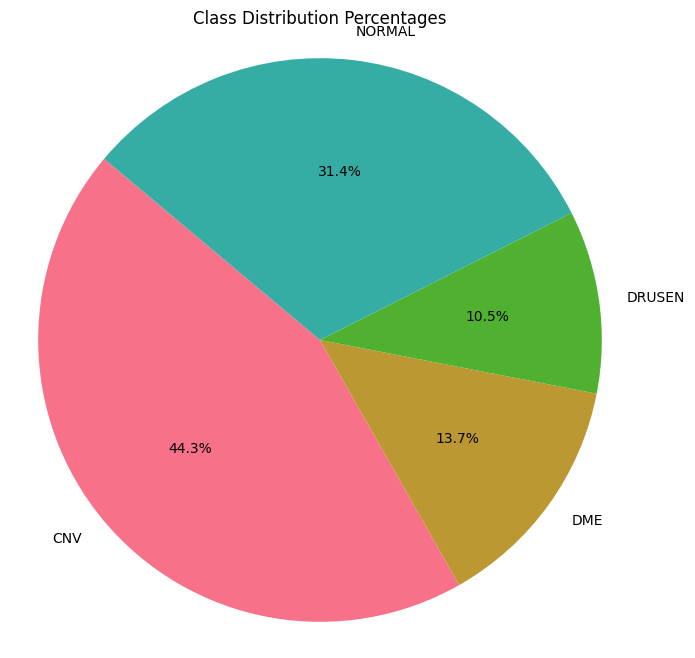

CNV: 44.33%
DME: 13.73%
DRUSEN: 10.50%
NORMAL: 31.44%

Significant class imbalance detected.
Consider applying data augmentation to underrepresented classes (e.g., DME, DRUSEN).


In [20]:
# Calculate class percentages if not already defined
total_images_all_classes = sum(total_per_class.values())
class_percentages = {cls: (count / total_images_all_classes) * 100 for cls, count in total_per_class.items()}

# Visualize class distribution percentages as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_percentages.values(), labels=class_percentages.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Percentages')
plt.axis('equal')
plt.show()

# Print class percentages
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

# Consider augmentation if imbalance exists
max_pct = max(class_percentages.values())
min_pct = min(class_percentages.values())
imbalance_threshold = 10  # percent difference threshold

if max_pct - min_pct > imbalance_threshold:
    print("\nSignificant class imbalance detected.")
    print("Consider applying data augmentation to underrepresented classes (e.g., DME, DRUSEN).")
else:
    print("\nNo significant class imbalance detected.")



## Patient Overlap and Demographics

We check for patient overlap between splits to ensure data independence and analyze demographic data if available.

**Key Findings:**
- Patient overlap between splits: train/test: `{len(overlap_train_test)}`, train/val: `{len(overlap_train_val)}`, test/val: `{len(overlap_test_val)}`.
- Demographic data summary provided if available.


In [21]:
# Metadata Analysis: Check for patient overlap between train/test/val

# Assuming filenames contain patient IDs, e.g., "PATIENTID-xxxx.jpeg"
def extract_patient_ids(folder_path):
    patient_ids = set()
    for cls in classes:
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            # Extract patient ID (assumes format: PATIENTID-xxxx.jpeg)
            patient_id = img_file.split('-')[1] if '-' in img_file else img_file
            patient_ids.add(patient_id)
    return patient_ids

train_patients = extract_patient_ids(os.path.join(base_path, 'train'))
test_patients = extract_patient_ids(os.path.join(base_path, 'test'))
val_patients = extract_patient_ids(os.path.join(base_path, 'val'))

# Check for overlaps
overlap_train_test = train_patients & test_patients
overlap_train_val = train_patients & val_patients
overlap_test_val = test_patients & val_patients

print(f"Patient overlap between train and test: {len(overlap_train_test)}")
print(f"Patient overlap between train and val: {len(overlap_train_val)}")
print(f"Patient overlap between test and val: {len(overlap_test_val)}")

# Analyze any available demographic data
# If demographic data is available in a CSV (e.g., 'demographics.csv'), load and summarize it
demographic_csv = os.path.join(base_path, 'demographics.csv')
if os.path.exists(demographic_csv):
    demo_df = pd.read_csv(demographic_csv)
    print("\nDemographic Data Overview:")
    print(demo_df.describe(include='all'))
    print("\nDemographic Columns:", demo_df.columns.tolist())
else:
    print("\nNo demographic data file found.")

Patient overlap between train and test: 546
Patient overlap between train and val: 21
Patient overlap between test and val: 2

No demographic data file found.



## Pixel Value Distribution and Normalization

We analyze the overall pixel value distribution to inform normalization strategies and suggest suitable augmentations.

**Key Findings:**
- Pixel values range from `{all_pixels_np.min()}` to `{all_pixels_np.max()}`.
- Mean and standard deviation are reported for normalization.
- Recommended augmentations are listed.


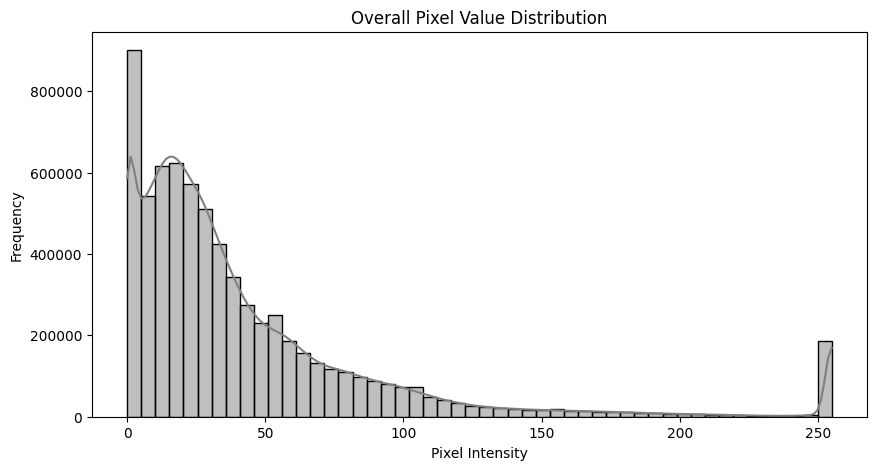

Pixel value range: 0 - 255
Mean pixel value: 43.86
Std pixel value: 50.95

Recommended augmentations that preserve class characteristics:
- Horizontal and vertical flips (retinal symmetry)
- Small rotations (±10 degrees, as large rotations may distort anatomy)
- Brightness and contrast adjustments (within reasonable limits)
- Random cropping and resizing (preserving central features)
- Gaussian noise addition (simulates sensor noise)
- Elastic deformations (with caution, to avoid unrealistic anatomy)


In [22]:
# Normalization Requirements: Analyze pixel value distributions
plt.figure(figsize=(10, 5))
sns.histplot(all_pixels, bins=50, kde=True, color='gray')
plt.title('Overall Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Print min/max/mean/std for pixel values
all_pixels_np = np.array(all_pixels, dtype=np.uint8)
print(f"Pixel value range: {all_pixels_np.min()} - {all_pixels_np.max()}")
print(f"Mean pixel value: {all_pixels_np.mean():.2f}")
print(f"Std pixel value: {all_pixels_np.std():.2f}")

# Augmentation Potential: Identify transformations that preserve class characteristics
augmentation_suggestions = [
    "Horizontal and vertical flips (retinal symmetry)",
    "Small rotations (±10 degrees, as large rotations may distort anatomy)",
    "Brightness and contrast adjustments (within reasonable limits)",
    "Random cropping and resizing (preserving central features)",
    "Gaussian noise addition (simulates sensor noise)",
    "Elastic deformations (with caution, to avoid unrealistic anatomy)"
]
print("\nRecommended augmentations that preserve class characteristics:")
for aug in augmentation_suggestions:
    print(f"- {aug}")